# 기계학습

### 담당교수 : 장원중

In [37]:
# 그래프 한글이 깨질때 & 마이너스 부호 사용

import sys, os
from matplotlib import font_manager, rc 
import matplotlib.pyplot as plt

# 한글 폰트 설정 : 윈도우 폰트를 사용하는 경우 
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name) 

# 운영체제별 한글 폰트 설정
# if os.name == 'posix': # Mac 환경 폰트 설정
#     rc('font', family='AppleGothic')
# elif os.name == 'nt': # Windows 환경 폰트 설정
#     rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 유니코드에서 음수 부호설정
rc('axes', unicode_minus=False)

# 부모 디렉터리의 파일을 가져올 수 있도록 설정
sys.path.append(os.pardir)     

# jupyter에서 matplotlib 그래프를 출력 영역에 표시  
%matplotlib inline 

# 레티나 설정 - 폰트 주변이 흐릿하게 보이는 것을 방지해 글씨가 좀 더 선명하게 보임
%config InlineBackend.figure_format = 'retina'

In [2]:
# 운영체제별 이름 

import platform

platform.system()

'Windows'

In [3]:
# 파이썬 버전 확인

import sys
import platform

print("--sys.version—")
print(sys.version)

print("--python_version—")
print(platform.python_version())

--sys.version—
3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
--python_version—
3.11.7


# [실습]주성분 분석: 주성분 분석이 모델의 성능을 높여줄 수 있는지에 알아봄

## 이터셋은 싸이킷 런의 wine 데이터를 사용해서 실습

#### 와인의 알코올 도수, 산도, 색깔, 등의 정보를 바탕으로 어떤 class의 와인인지 알아보는 모델을 LogisticRegression을 사용해서 분류할 것임

#### 이때, PCA를 사용하는 것과 사용하지 않은 것을 두 가지를 진행할 것이며 이를 비교함

In [4]:
# 사용한 Library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# 와인 데이터 불러오기
data = datasets.load_wine()

print(type(data))
print(data.keys())

# Bunch 객체는 몇 가지의 key를 제공하며 이를 통해 데이터의 정보를 쉽게 확인할 수 있음 

# dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names']) 
# data, target, target_names 등 주요 key를 제공하며, 분류나 회귀 데이터에 따라 속성이 약간 다름 
# - data : 모델에 제공할 학습 데이터
# - target : 정답 데이터, 라벨(label), 클래스(class) 데이터
# - target_name : 라벨, 클래스 이름
# - feature_name : 피쳐 이름, 속성 이름 

<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])


In [8]:
# 와인 데이터

X = data.data
y = data.target
feature_names = data.feature_names
print(data.target_names)    # ['class_0' 'class_1' 'class_2'] 
print(data.feature_names)
# ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 
#  'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 
#  'od280/od315_of_diluted_wines', 'proline']

# 종속 변수는 ['class_0' 'class_1' 'class_2']으로 3개의 class로 분류되어 있음
# 독립 변수는 ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 
#             'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']을 총 13개가 있는 것을 확인할 수 있음 

['class_0' 'class_1' 'class_2']
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


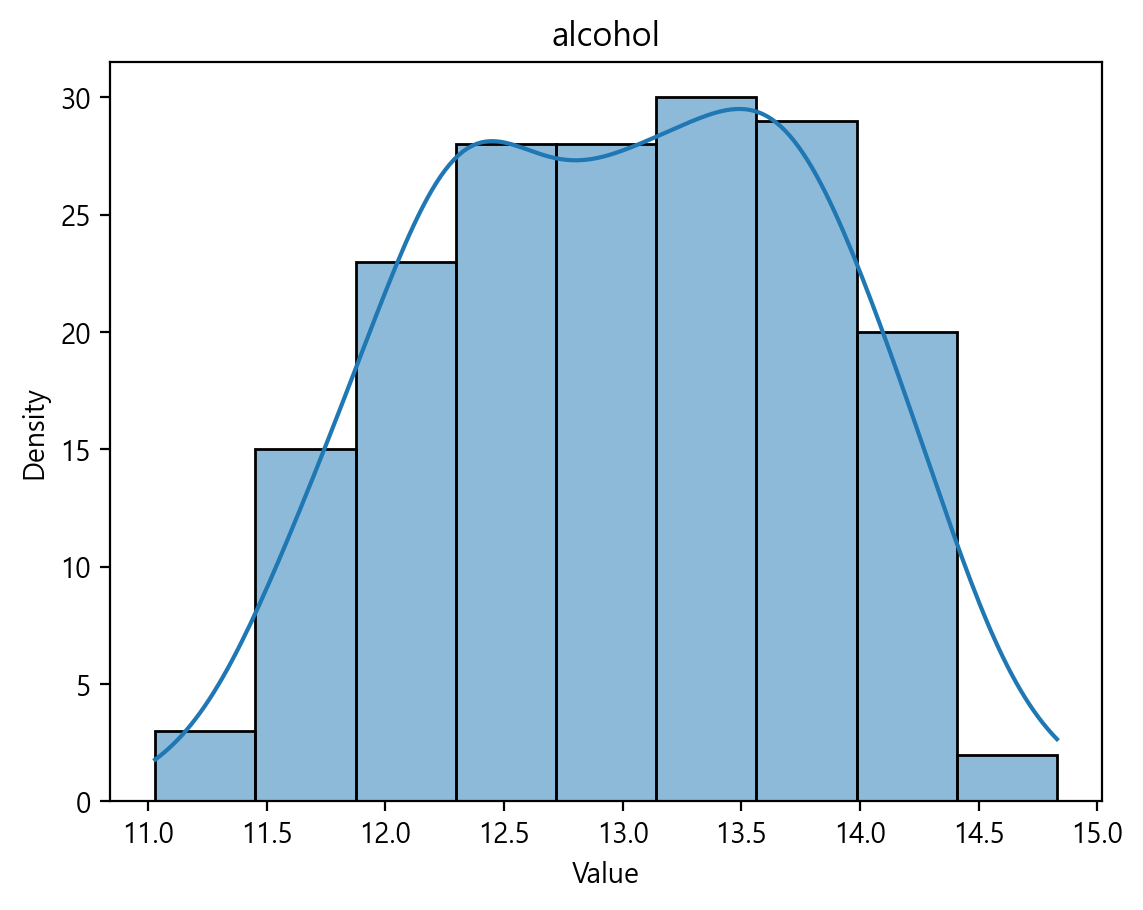

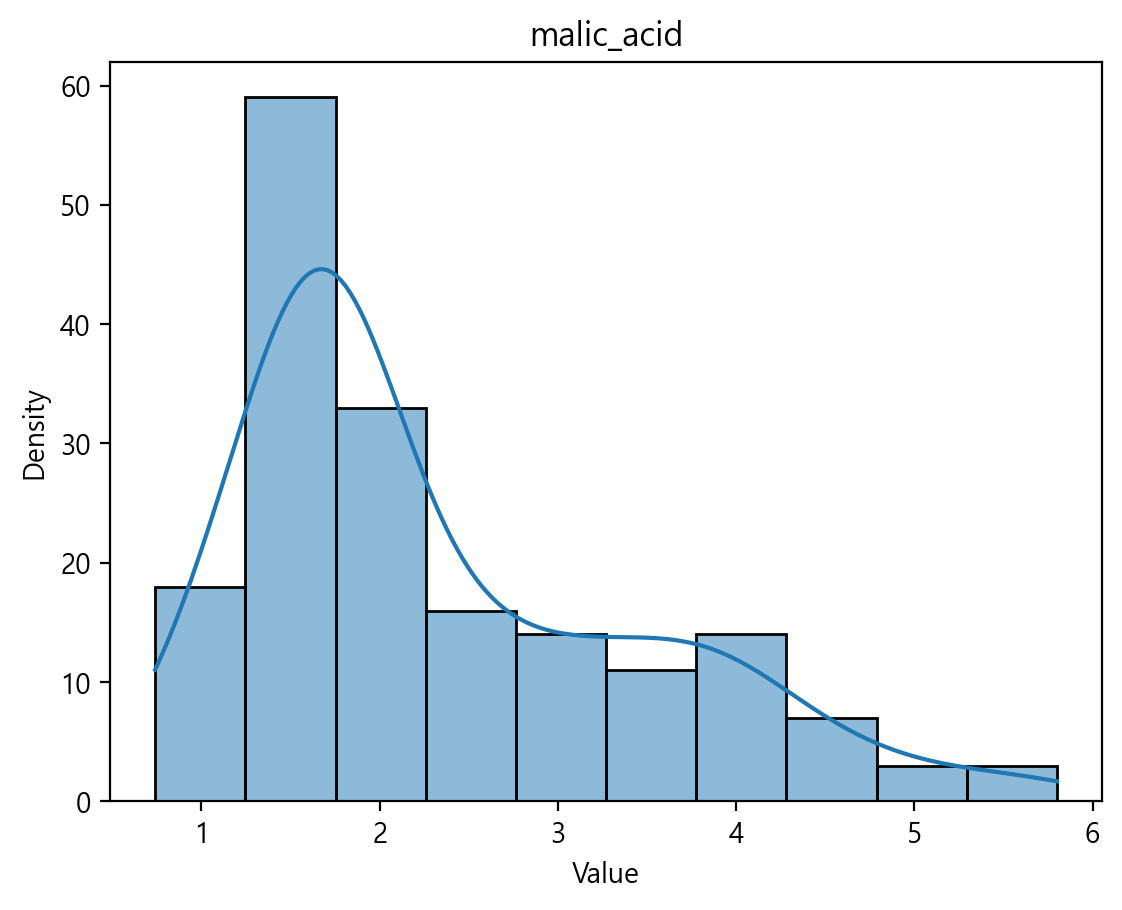

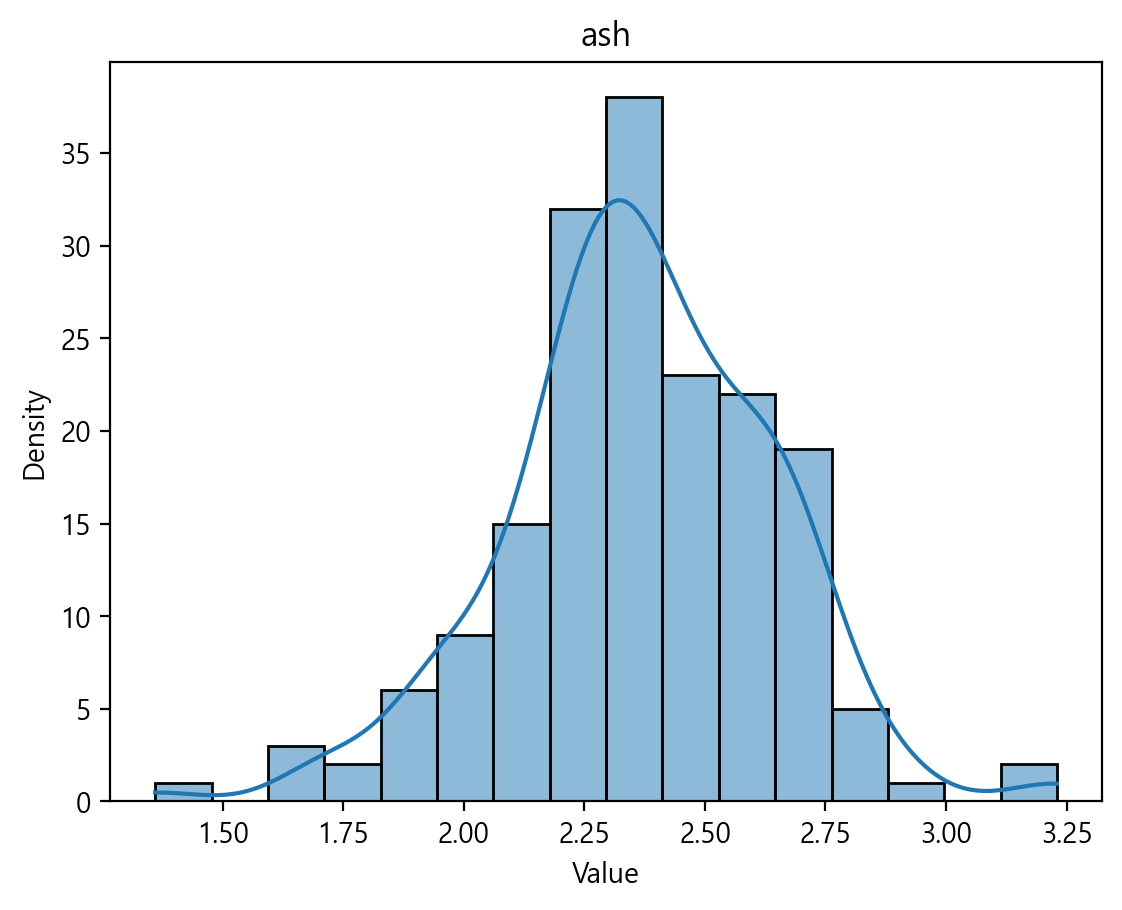

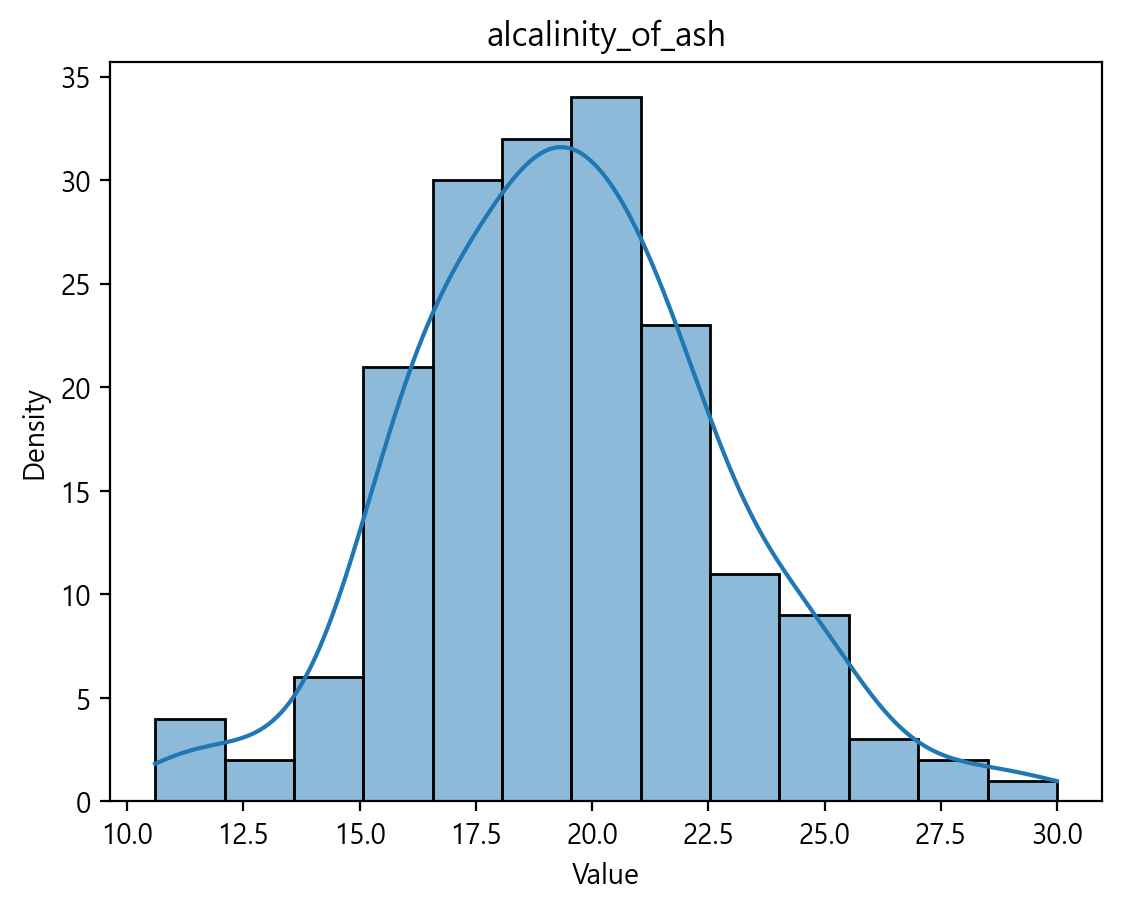

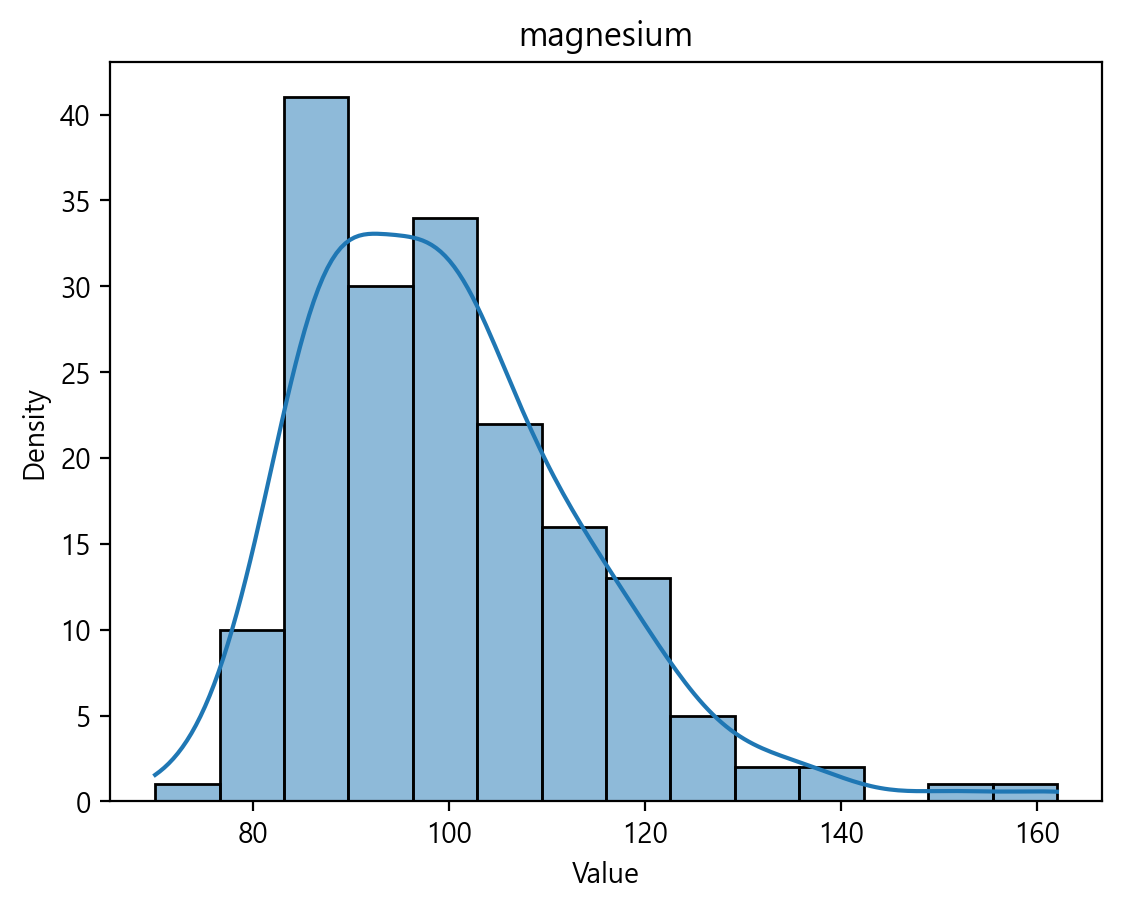

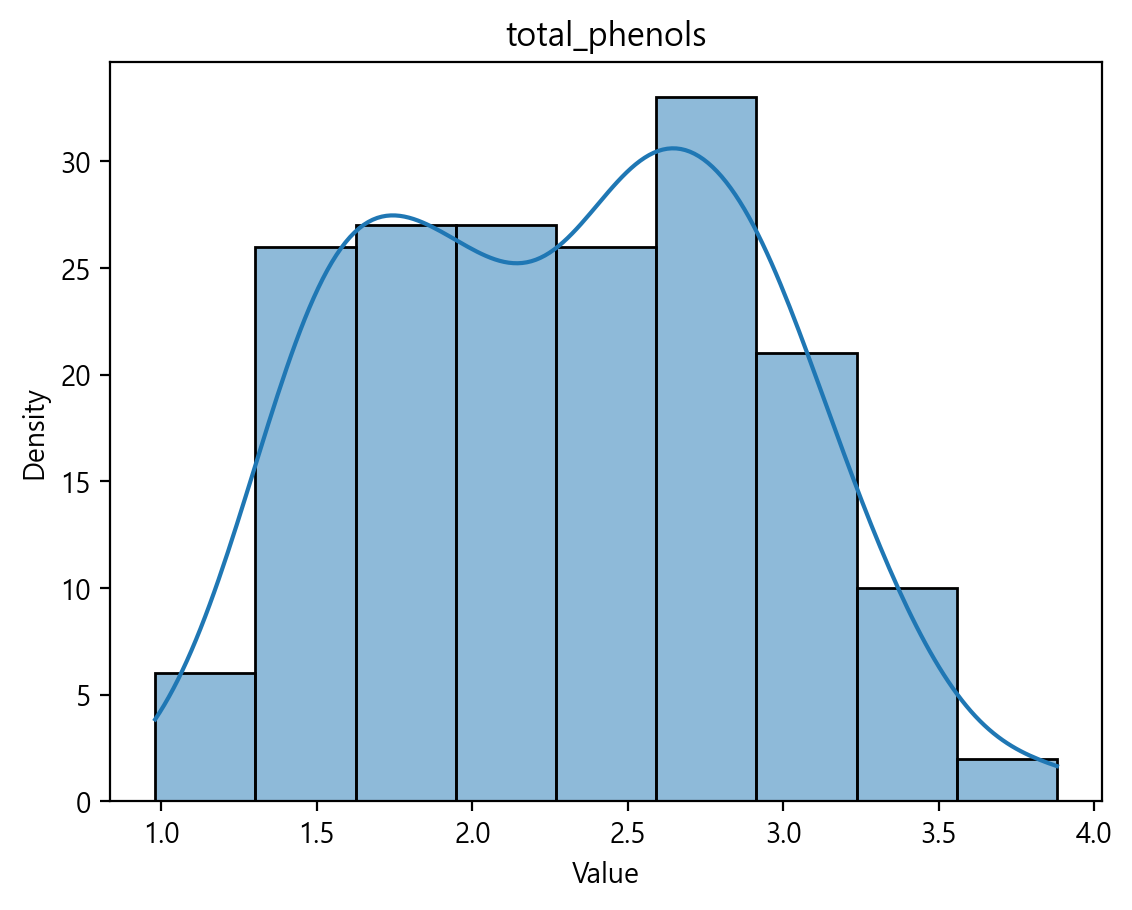

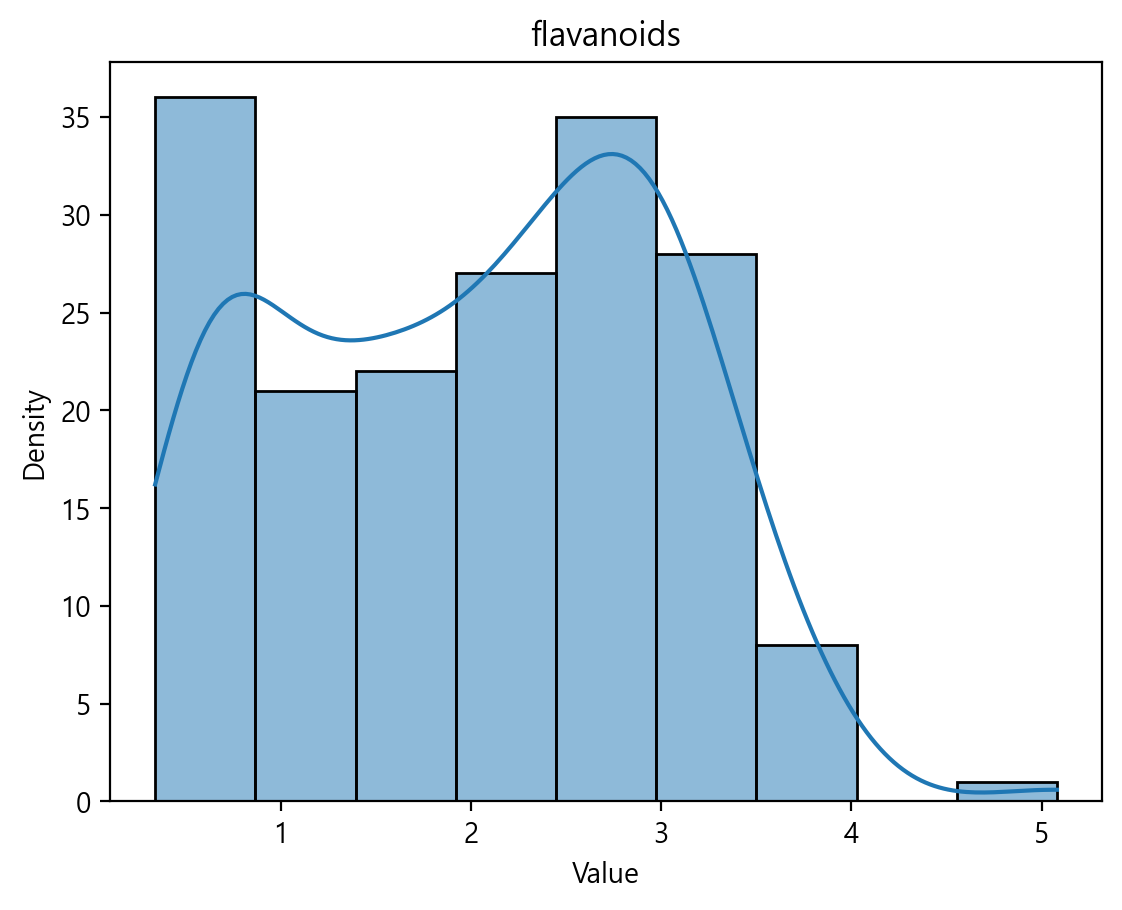

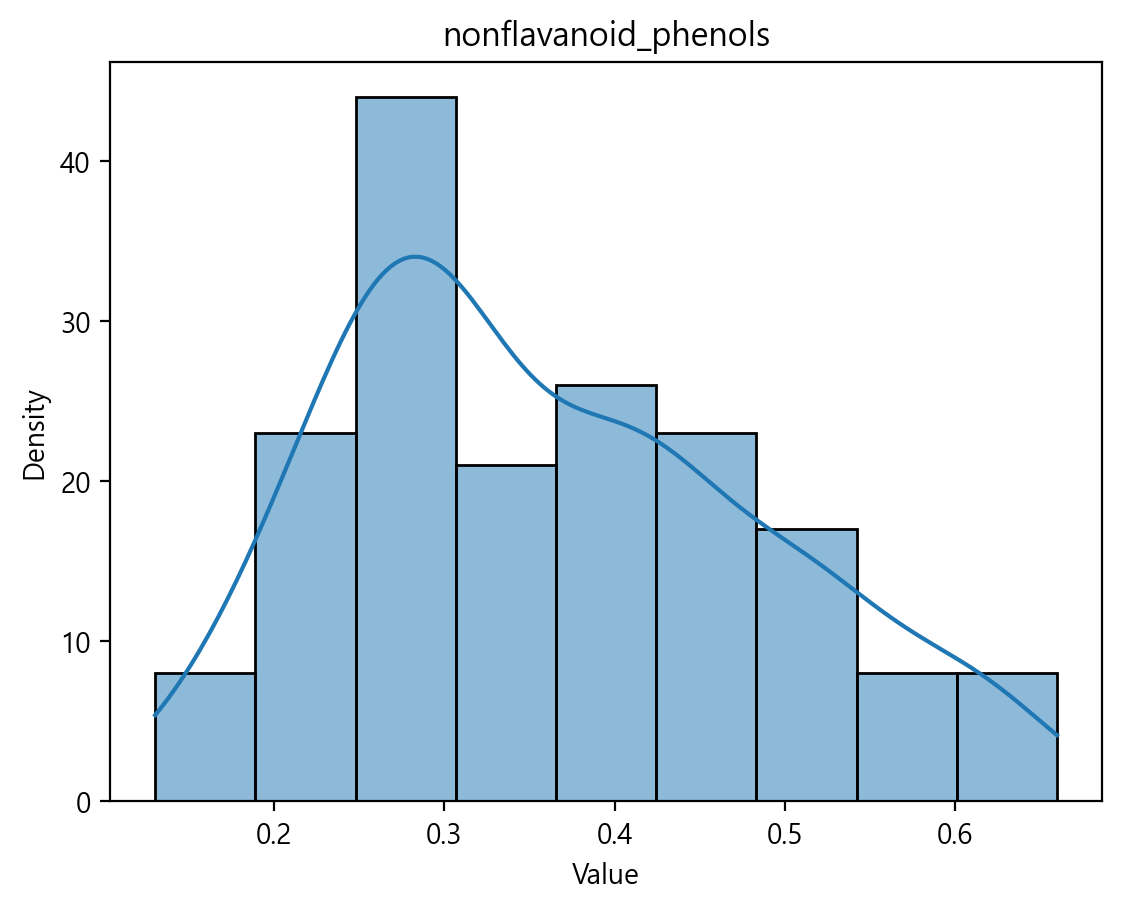

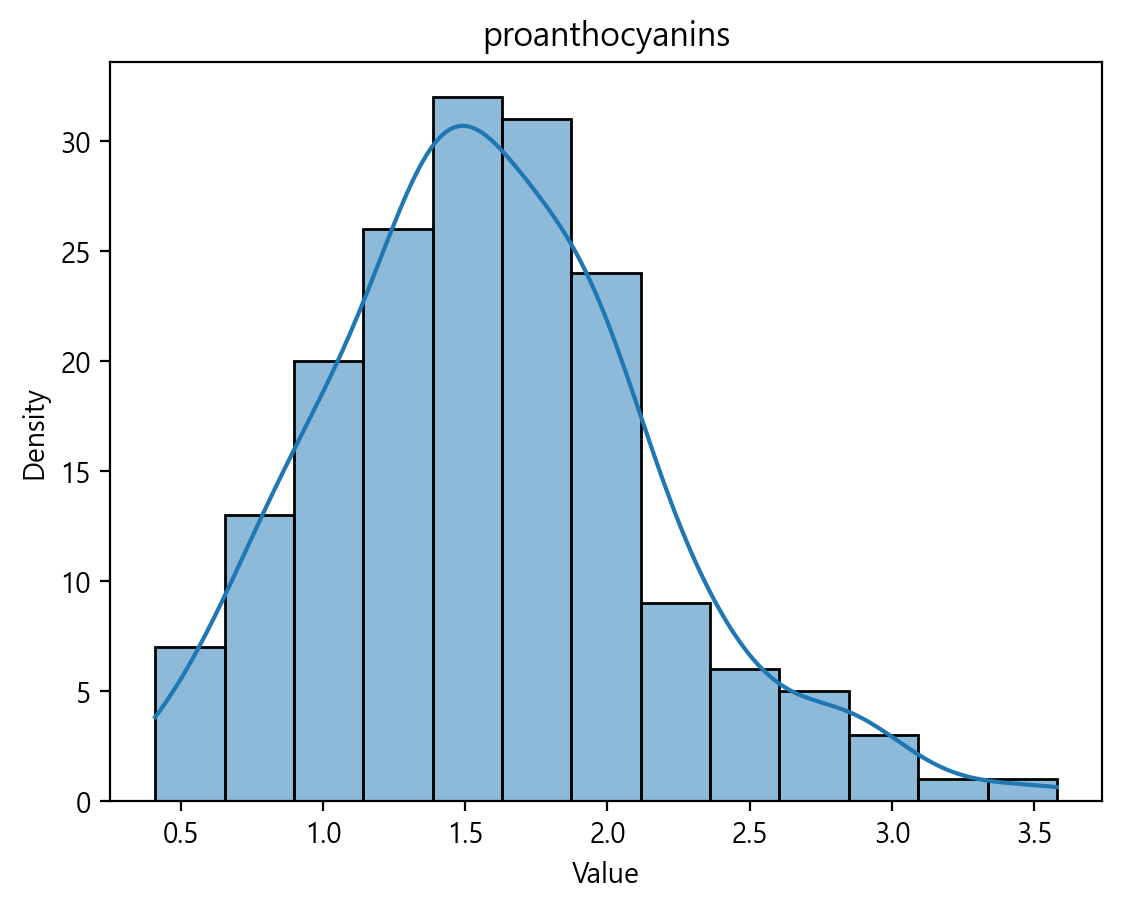

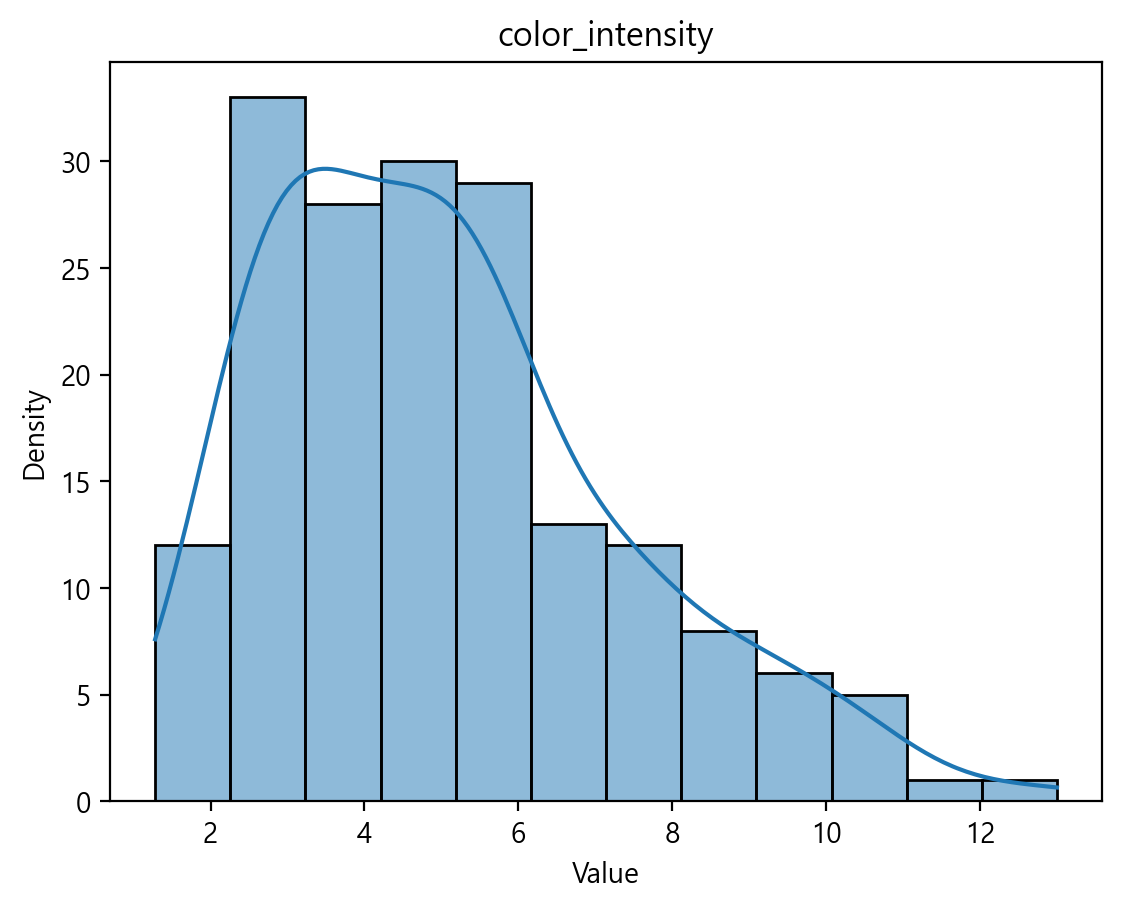

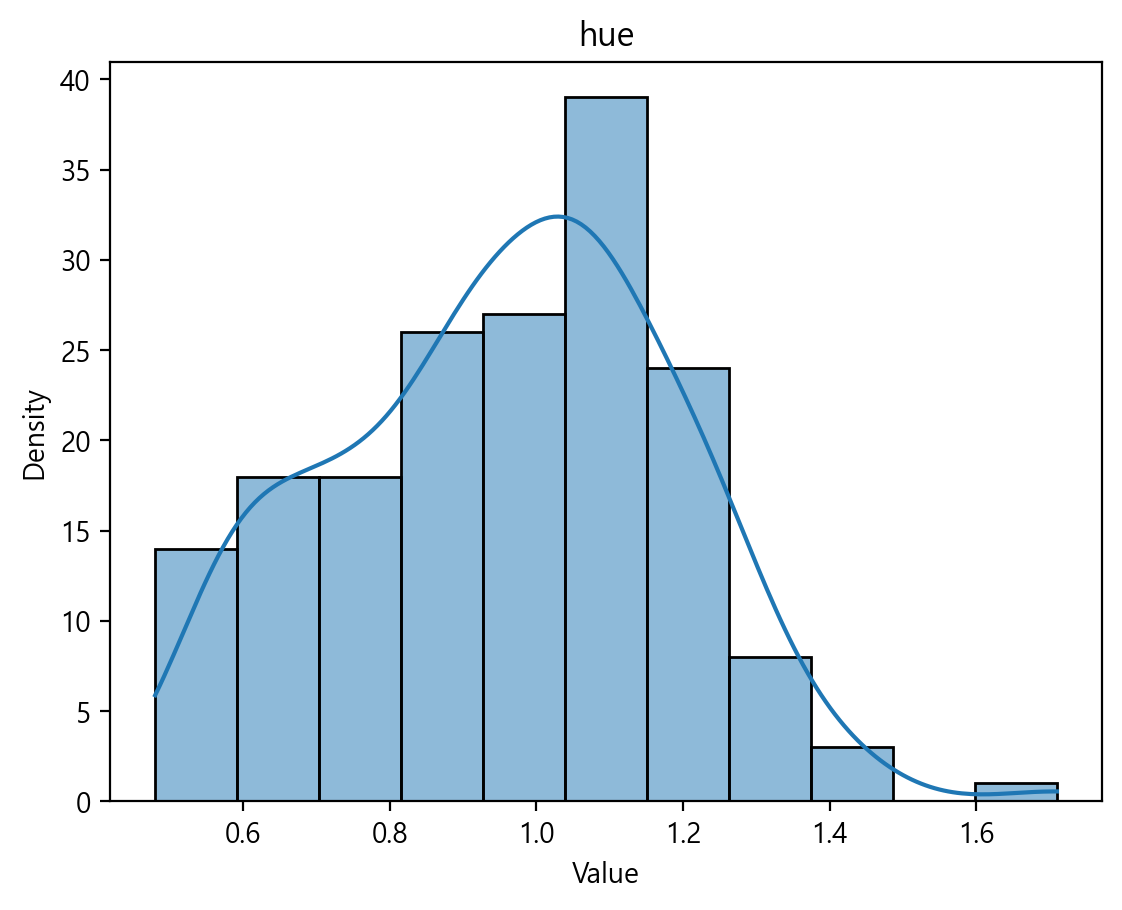

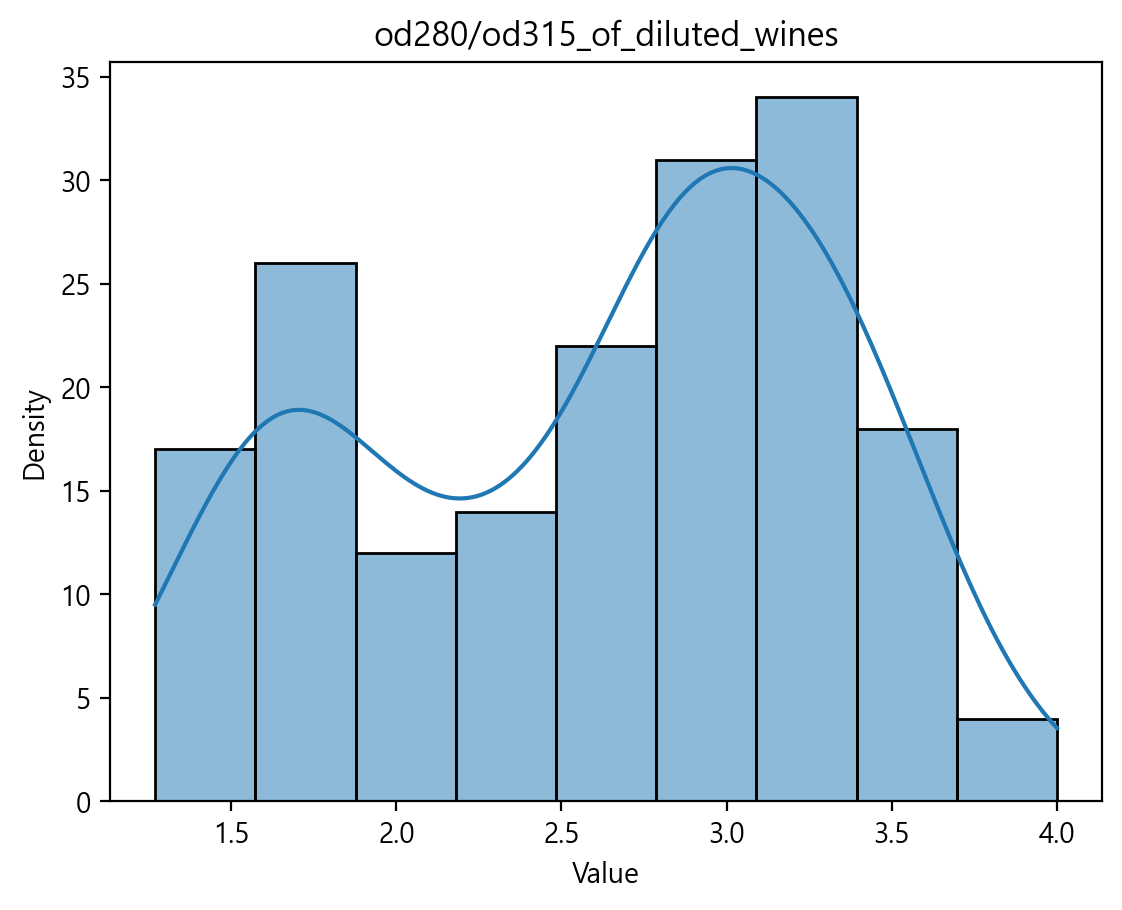

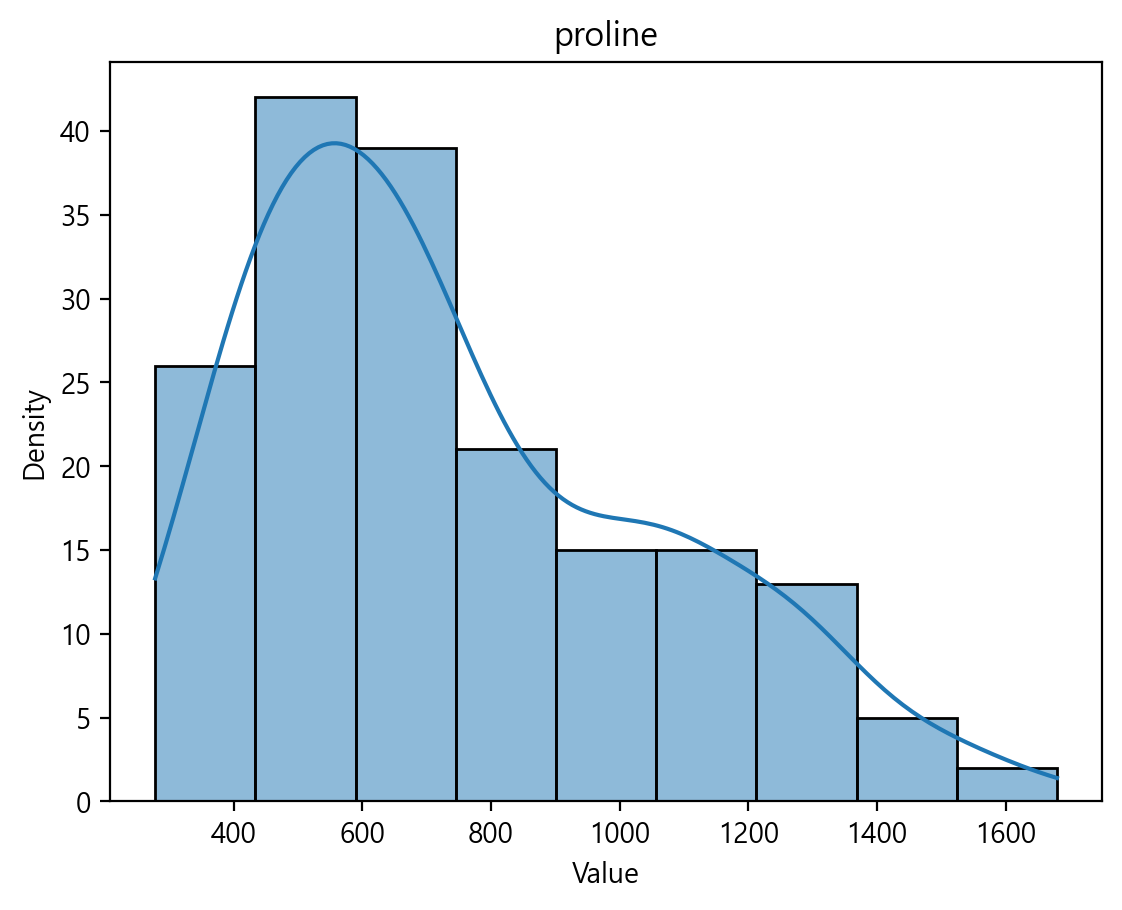

In [10]:
# 설명 변수들의 분포를 확인하며 정규성을 띄는지 확인해 봄
dfX = pd.DataFrame(X)
dfy = pd.DataFrame(y)

# DataFrame의 각 열에 대해 분포 플롯 그리기
for i in range(dfX.shape[1]):
    sns.histplot(dfX.iloc[:, i], kde=True)  # kde=True를 통해 KDE 곡선을 추가할 수 있음 
    plt.title(feature_names[i])
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()
# 변수(Features)들은 정규분포에 가까운 그래프를 그려주는 것을 확인할 수 있음 

1    71
0    59
2    48
Name: 0, dtype: int64

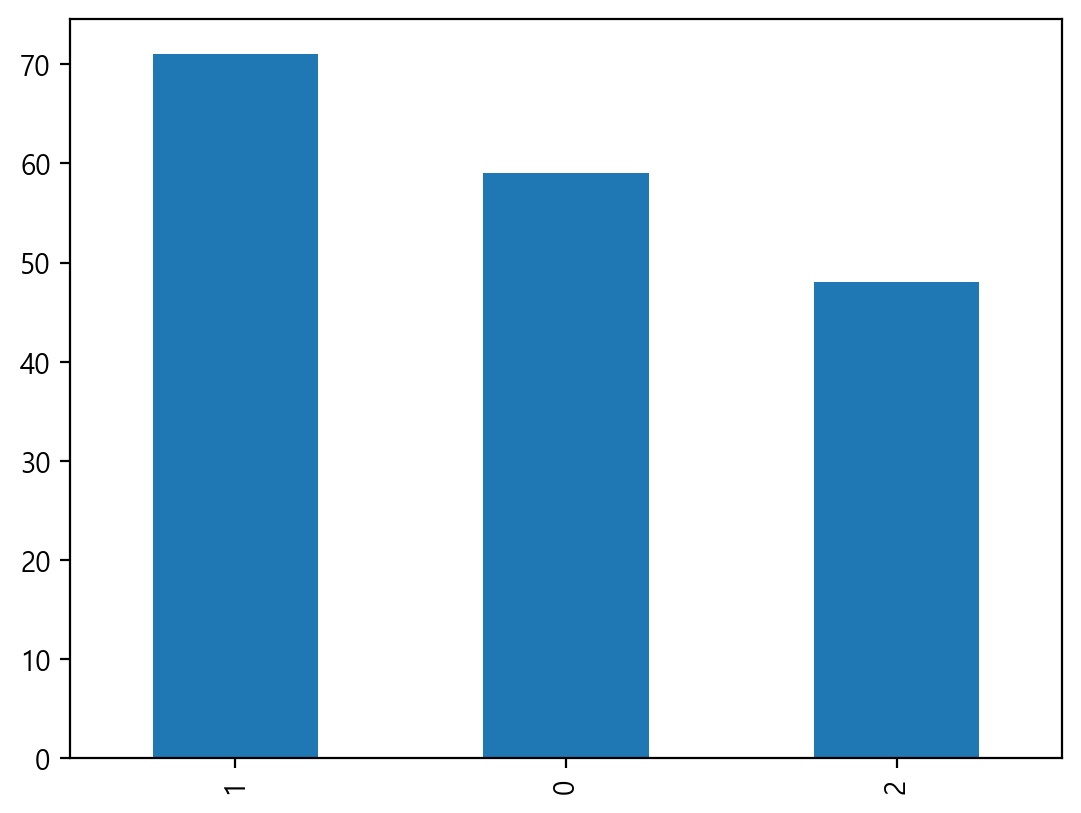

In [10]:
# 종속 변수가 골고루 있는지 확인해 봄 

pd.DataFrame(y)[0].value_counts().plot(kind='bar')
pd.DataFrame(y)[0].value_counts()

In [13]:
# 와인 데이터셋에서 훈련(train) 데이터를 80%, 시험(test) 데이터를 20%로 데이터 분류
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(x_train.shape)  # (142, 13)
print(y_train.shape)  # (142,)
print(x_test.shape)   # (36, 13)
print(y_test.shape)   # (36,)

(142, 13)
(142,)
(36, 13)
(36,)


In [14]:
# 로지스틱 회귀 모델 적용
# 데이터 가공 없이 로지스틱 회귀 모델을 사용해서 모델의 성능을 확인해 봄 

# 모델 생성 / 최대 iter 2000 / 다중 분류이므로 multi_class 적용
clf = LogisticRegression(max_iter=2000, random_state=0, multi_class='multinomial', solver='sag')
clf.fit(x_train, y_train)     # 학습

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=2000, multi_class='multinomial', random_state=0,
                   solver='sag')

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 예측
y_pred = clf.predict(x_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
# 97%의 정확도를 가지는 것을 확인할 수 있음 

Accuracy: 0.9722222222222222
Confusion Matrix:
[[13  1  0]
 [ 0 16  0]
 [ 0  0  6]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.94      1.00      0.97        16
           2       1.00      1.00      1.00         6

    accuracy                           0.97        36
   macro avg       0.98      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36



## PCA(주성분 분석) 적용 

In [17]:
# PCA 모델 생성하여 와인 데이터 전체의 독립변수로 학습함  
pca = PCA()
pca.fit(X)

# 주성분 분석 클래스의 객체를 이용해 독립변수를 변환하여 PC score를 구함 
pcscore = pca.transform(X)

In [35]:
# 설명된 분산(explained_variance)를 통해서 PC값 들의 설명 정도를 확인할 수 있음
# 설명된 분산(explained_variance)은 고유값(eigenvalue)의 의미와 같음     

# 각 PC 축이 가지는 설명력 정도를 설명된 분산(pca.explained_variance_) 값을 통해서 알 수 있음 
print(pca.explained_variance_)

# 고유값으로 설명된 분산의 비율(explained variance ratio)을 계산함   
print(pca.explained_variance_ / np.sum(pca.explained_variance_)) 

[9.92017895e+04 1.72535266e+02 9.43811370e+00 4.99117861e+00
 1.22884523e+00 8.41063869e-01 2.78973523e-01 1.51381266e-01
 1.12096765e-01 7.17026032e-02 3.75759789e-02 2.10723661e-02
 8.20370314e-03]
[9.98091230e-01 1.73591562e-03 9.49589576e-05 5.02173562e-05
 1.23636847e-05 8.46213034e-06 2.80681456e-06 1.52308053e-06
 1.12783044e-06 7.21415811e-07 3.78060267e-07 2.12013755e-07
 8.25392788e-08]


In [36]:
print(9.98091230e-01)

0.99809123


[9.98091230e-01 1.73591562e-03 9.49589576e-05 5.02173562e-05
 1.23636847e-05 8.46213034e-06 2.80681456e-06 1.52308053e-06
 1.12783044e-06 7.21415811e-07 3.78060267e-07 2.12013755e-07
 8.25392788e-08]


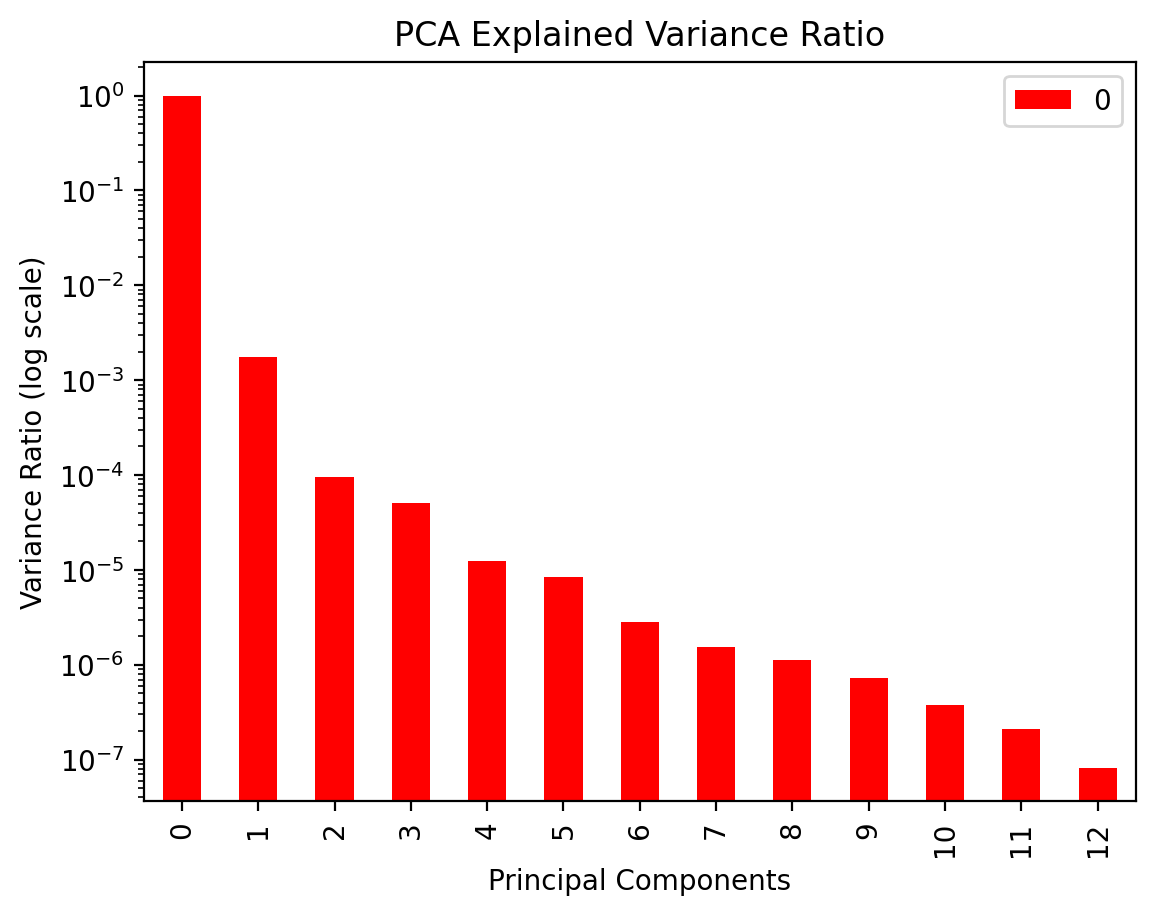

In [34]:
# 설명된 분산의 비율(explained variance ratio)을 확인할 수 있음 
# 설명도 정도를 그래프를 통해서 확인
# 설명 정도의 값의 차이가 너무 커서 모두 같은 크기의 막대그래프가 그려져서 sacle을 log로 설정
# 첫 번째 PC의 설명도가 상당히 높은 것을 확인할 수 있음 
# 설명도 정도를 비율로 확인할 수도 있음 
# 아래의 그래프를 통해서 각 PC축들이 가지는 설명력을 시각적으로 알 수 있음 

# CMU fonts available here : https://www.1001fonts.com/download/cmu.zip
plt.rcParams["font.family"] = ["DejaVu Sans"]

PC_ratio = pca.explained_variance_ratio_
PC_ratio_df = pd.DataFrame(PC_ratio)
print(PC_ratio)

# 막대 그래프 그리기
PC_ratio_df.plot(kind='bar', logy=True, color='r')
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio (log scale)')
plt.show()

In [39]:
# pca 적용하지 않은 데이터와 적용한 데이터에 동일하게 적용할 로지스틱회귀모델 생성
# 모델 생성 / 최대 iter 2000 / 다중 분류이므로 multi_class 적용
clf2 = LogisticRegression(max_iter=2000, random_state=0, multi_class='multinomial', solver='sag')

In [40]:
# 훈련 데이터셋으로 PCA 모델 학습 
pca = PCA()
pca.fit(x_train)

# 훈련 데이터셋으로 학습된 PCA 모델로 훈현 데이터와 시험 데이터 변환 
# PC score 구하기 : 훈련 데이터, 시험 데이터 
train_score = pca.transform(x_train)
test_score = pca.transform(x_test)

In [41]:
# 모델 적용 및 비교
# pca 적용하지 않은 데이터로 로지스틱 회귀 모델 학습, 예측, 평가  
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
cf1 = confusion_matrix(y_test, pred)
print(cf1)
print(accuracy_score(y_test, pred))

# pca 적용한 데이터로 로지스틱 회귀 모델 학습, 예측, 평가  
clf2.fit(train_score, y_train)
pred2 = clf2.predict(test_score)
cf2 = confusion_matrix(y_test, pred2)
print(cf2)
print(accuracy_score(y_test, pred2))
# PCA를 적용한 것과 적용하지 않은 것 모두 97.22%의 정확도를 보여주었음 
# 또한 동일한 confusion matrix를 가지는 것을 통해서 같은 모델이라고 생각할 수 있음 
# 즉, 모든 feature들을 사용할 경우 pca를 적용한 것과 적용하지 않은 것의 차이가 없는 것으로 생각할 수 있음 

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[[13  1  0]
 [ 0 16  0]
 [ 0  0  6]]
0.9722222222222222
[[13  1  0]
 [ 0 16  0]
 [ 0  0  6]]
0.9722222222222222


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [42]:
# 2차원 모델 
# 설명 변수를 2개만 사용해서 모델을 생성하고 결과를 확인 
# 2개의 columns만을 사용하기 때문에 설명력이 떨어질 것이고 결과가 좋지 않을 수 있다는 것을 감안하고 진행함
# 2개의 feature만을 사용해서 모델 생성 및 예측

# Raw Data
clf.fit(x_train[:,:2], y_train)
pred = clf.predict(x_test[:,:2])
cf1 = confusion_matrix(y_test, pred)
print(cf1)
print(accuracy_score(y_test, pred))

# PC score
clf2.fit(train_score[:,:2], y_train)
pred2 = clf2.predict(test_score[:,:2])
cf2 = confusion_matrix(y_test, pred2)
print(cf2)
print(accuracy_score(y_test, pred2))

# 첫 두 개의 feature만을 사용해서 모델을 생성하고 test case를 예측하면 큰 차이를 보이는 것을 확인할 수 있음  
# 기존의 Raw Data의 경우는 약 70%의 정확도를 가지고 PCA 적용 모델은 83%의 정확도를 가지고 있음 
# PCA가 더 좋은 성능을 보이고 있음
# 하지만, pca의 경우 기본적으로 설명력이 높은 순서대로 정렬이 되어있기 때문에 앞쪽의 데이터를 사용하면 설명력 차이로 인해서 pca를 적용한 모델이 높을 수밖에 없음

[[10  2  2]
 [ 1 13  2]
 [ 3  1  2]]
0.6944444444444444
[[13  0  1]
 [ 0 16  0]
 [ 1  4  1]]
0.8333333333333334


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [55]:
# alcohol malic_acid
print(feature_names[0],feature_names[1])

alcohol malic_acid


In [47]:
# 조합 case를 만들기 위한 library
from itertools import combinations

# 점수들을 모두 담기 위한 빈 리스트
score_board = []

# 순서가 없고 조합되지 않은 모든 케이스에 대해서 모델을 생성하고 결과를 확인
for comb in combinations(list(range(0,x_train.shape[1])),2):
    clf.fit(x_train[:,comb],y_train)
    pred = clf.predict(x_test[:,comb])
    score = accuracy_score(y_test, pred)
    score_board.append(score)
    print(comb)
    print(score)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(0, 1)
0.6944444444444444
(0, 2)
0.7222222222222222
(0, 3)
0.8055555555555556


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(0, 4)
0.5555555555555556
(0, 5)
0.8888888888888888
(0, 6)
0.8333333333333334
(0, 7)
0.6944444444444444
(0, 8)
0.6944444444444444
(0, 9)
0.7777777777777778
(0, 10)
0.8611111111111112
(0, 11)
0.8333333333333334


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(0, 12)
0.8333333333333334
(1, 2)
0.6388888888888888
(1, 3)
0.6388888888888888
(1, 4)
0.5277777777777778
(1, 5)
0.6666666666666666
(1, 6)
0.7222222222222222
(1, 7)
0.4444444444444444
(1, 8)
0.5277777777777778
(1, 9)
0.8055555555555556
(1, 10)
0.5555555555555556
(1, 11)
0.5555555555555556


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(1, 12)
0.4722222222222222
(2, 3)
0.7222222222222222
(2, 4)
0.5
(2, 5)
0.75
(2, 6)
0.7777777777777778
(2, 7)
0.6388888888888888
(2, 8)
0.6111111111111112
(2, 9)
0.6944444444444444
(2, 10)
0.7222222222222222
(2, 11)
0.6944444444444444


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(2, 12)
0.5555555555555556
(3, 4)
0.7222222222222222
(3, 5)
0.7222222222222222
(3, 6)
0.75
(3, 7)
0.6388888888888888
(3, 8)
0.6388888888888888
(3, 9)
0.7777777777777778
(3, 10)
0.6666666666666666
(3, 11)
0.7222222222222222
(3, 12)
0.7222222222222222


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(4, 5)
0.5555555555555556
(4, 6)
0.6388888888888888
(4, 7)
0.6944444444444444


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(4, 8)
0.6111111111111112
(4, 9)
0.7222222222222222
(4, 10)
0.6944444444444444


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(4, 11)
0.6666666666666666
(4, 12)
0.7222222222222222
(5, 6)
0.7222222222222222
(5, 7)
0.6388888888888888
(5, 8)
0.6388888888888888
(5, 9)
0.8333333333333334
(5, 10)
0.7222222222222222
(5, 11)
0.6944444444444444
(5, 12)
0.5555555555555556


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(6, 7)
0.7222222222222222
(6, 8)
0.75
(6, 9)
0.8333333333333334
(6, 10)
0.7777777777777778
(6, 11)
0.7222222222222222
(6, 12)
0.4722222222222222
(7, 8)
0.5
(7, 9)
0.7222222222222222
(7, 10)
0.5833333333333334
(7, 11)
0.5833333333333334


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(7, 12)
0.3888888888888889
(8, 9)
0.8055555555555556
(8, 10)
0.5555555555555556
(8, 11)
0.5555555555555556
(8, 12)
0.4444444444444444
(9, 10)
0.8611111111111112
(9, 11)
0.8055555555555556
(9, 12)
0.5277777777777778
(10, 11)
0.5833333333333334
(10, 12)
0.4166666666666667
(11, 12)
0.6111111111111112


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [57]:
# 0번째, 5번째 위치의 독립 변수: alcohol total_phenols
print(feature_names[0],feature_names[5])

# 최대 점수 확인
print(max(score_board))

# 최대 점수의 경우는 88.88%의 정확도를 가지고 있음
# 즉 PCA를 사용한 것보다 더 정확도가 높은 것을 볼 수 있음

print(x_train[:,[0,5]])

alcohol total_phenols
0.8888888888888888
[[13.69  1.83]
 [12.69  1.38]
 [11.62  3.02]
 [13.4   1.8 ]
 [13.5   2.53]
 [13.73  3.  ]
 [12.29  2.45]
 [12.6   1.45]
 [11.41  2.48]
 [13.64  2.7 ]
 [12.6   1.62]
 [11.96  3.38]
 [12.25  1.38]
 [14.3   2.8 ]
 [12.88  1.3 ]
 [13.49  1.62]
 [13.56  3.15]
 [14.34  2.8 ]
 [13.71  2.61]
 [12.22  2.36]
 [13.27  1.59]
 [13.16  1.5 ]
 [13.86  2.95]
 [12.85  1.65]
 [13.84  1.8 ]
 [13.3   2.4 ]
 [13.05  1.65]
 [12.51  2.  ]
 [12.29  2.55]
 [12.77  1.63]
 [12.96  1.39]
 [13.67  2.1 ]
 [13.16  2.8 ]
 [12.37  1.98]
 [12.47  2.5 ]
 [11.81  1.6 ]
 [13.24  2.64]
 [14.1   2.95]
 [11.61  2.74]
 [12.99  3.3 ]
 [12.77  1.39]
 [13.48  2.6 ]
 [11.46  3.18]
 [12.07  2.6 ]
 [11.82  1.98]
 [13.45  1.7 ]
 [12.2   1.25]
 [13.05  2.72]
 [13.17  1.74]
 [12.08  2.2 ]
 [12.17  1.89]
 [12.42  2.2 ]
 [11.87  2.86]
 [12.21  1.85]
 [13.94  2.88]
 [14.1   2.75]
 [12.67  2.2 ]
 [14.75  3.1 ]
 [12.25  1.38]
 [12.85  2.48]
 [13.73  1.28]
 [14.06  3.  ]
 [13.63  2.85]
 [12.33  1.9 ]

In [ ]:
# 결론
# 데이터와 변수(feature)에 따라서 상황은 다르지만 pca가 더 좋거나 raw_data가 더 좋다고 할 수는 없음
# 현재 자신이 분석하는 데이터와 상황에 따라서 적절하게 맞는 것을 확인해서 사용해야 할 것임
# 가장 높은 정확도는 raw_Data 중에서 뽑는 것이 더 좋은 결과를 가지고 있음
# 하지만, 위의 연습용 데이터처럼 얼마 되지 않은 데이터의 경우는 큰 문제가 없지만, 
#        현업에서의 아주 큰 데이터와 수백 개가 넘는 변수(feature)가 있는 경우에는 모든 경우를 확인하기 어려울 것임
# 변수(feature) 간의 관계를 다 파악하고 어떤 독립변수가 설명력이 높은지 찾는 데까지 생각보다 시간이 오래 걸릴 수 있음
# 따라서, 피쳐 선택(feature selection)을 통해서 설명력이 높은  변수(feature)들을 찾아 뽑아서 사용해야 할 것임

In [ ]:
# 요약
# PCA가 모델의 성능을 높여주는 것은 아님
# 하지만, 빠르게 필요 없는 변수(feature)들을 없애고 핵심적인 변수(feature) 들만을 뽑아서 모델을 만드는 것에는 유용할 것임